In [1]:
import numpy as np
import robosuite as suite
from robosuite.environments.manipulation.empty import Empty
from scipy import interpolate
from robosuite.utils.mjmod import DynamicsModder

In [2]:
horizon = 200

In [3]:
def plan(start_pose, middle_pose, end_pose, horizon):
    cs = interpolate.CubicSpline([0, horizon // 2, horizon], [start_pose, middle_pose, end_pose], 
                                       axis=0, bc_type='clamped')
    return cs(range(horizon))  
def difference(traj):
    traj = np.array(traj)
    new_traj = [traj[0]]
    for i in range(len(traj)):
        if i == 0:
            continue
        new_traj.append(traj[i] - traj[i - 1])
    return new_traj

In [4]:
suite.environments.base.register_env(Empty)

In [5]:
controller_config = suite.load_controller_config(default_controller="JOINT_POSITION")
controller_config["damping_ratio"] = 0.1
controller_config["ramp_ratio"] = 0.1
print(controller_config)

{'type': 'JOINT_POSITION', 'input_max': 1, 'input_min': -1, 'output_max': 0.05, 'output_min': -0.05, 'kp': 50, 'damping_ratio': 0.1, 'impedance_mode': 'fixed', 'kp_limits': [0, 300], 'damping_ratio_limits': [0, 10], 'qpos_limits': None, 'interpolation': None, 'ramp_ratio': 0.1}


In [6]:
env = suite.make(
    "Empty",
    robots="IIWA",             # load a Sawyer robot and a Panda robot
    gripper_types="ClothGripper",                # use default grippers per robot arm
    controller_configs=controller_config, 
    has_renderer=True,                      # on-screen rendering
    render_camera="sideview",              # visualize the "frontview" camera
    has_offscreen_renderer=False,           # no off-screen rendering
    render_collision_mesh=True,
    control_freq=20,                        # 20 hz control for applied actions
    horizon=horizon,                            # each episode terminates after 200 steps
    use_object_obs=False,                   # no observations needed
    use_camera_obs=False,                   # no observations needed
)

Creating window glfw


In [7]:
import tqdm
import random

num_dataset_size = 10
num_cloth_joints = 11

all_geom_positions = []
all_parameters = []
for _ in tqdm.tqdm(range(num_dataset_size)):
    done = False
    obs = env.reset()
    
    modder = DynamicsModder(sim=env.sim)
    damping = random.random() * 20
    stiffness = random.random() * 20
    all_parameters.append([damping, stiffness])
    
    for i in range(num_cloth_joints):
        modder.mod("gripper0_joint" + str(i), "damping", damping)
        modder.mod("gripper0_joint" + str(i), "stiffness", stiffness)
    
    geom_positions = []
    traj = difference(plan([0, 0, 0, 0, 0, 0, 0], [0, -10, 0, 10, 0, -10, 0], [0, 0, 0, 0, 0, 0, 0], horizon))
    while not done:
        action = traj[i]
        for j in range(num_cloth_joints):
            pos = env.sim.data.geom_xpos[env.sim.model.geom_name2id("gripper0_g{}_col".format(j))]
            geom_positions.append(pos[0])
            geom_positions.append(pos[2])
        obs, reward, done, info = env.step(action) 
#         env.render()
    all_geom_positions.append(geom_positions)
    
all_geom_positions = np.array(all_geom_positions)
all_parameters = np.array(all_parameters)

  0%|          | 0/10 [00:00<?, ?it/s]

Creating window glfw


 10%|█         | 1/10 [00:02<00:24,  2.70s/it]

Creating window glfw


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

Creating window glfw


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

Creating window glfw


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

Creating window glfw


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

Creating window glfw


 60%|██████    | 6/10 [00:17<00:12,  3.00s/it]

Creating window glfw


 70%|███████   | 7/10 [00:21<00:09,  3.09s/it]

Creating window glfw


 80%|████████  | 8/10 [00:24<00:06,  3.21s/it]

Creating window glfw


 90%|█████████ | 9/10 [00:27<00:03,  3.14s/it]

Creating window glfw


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


In [8]:
# Have some prior distribution of magazine parameters
# Model predicts parameters distribution from actions and movement
# Each cycle
# Sample parameters and choose actions to minimize entropy of predictions

In [9]:
# Use DIAYN for trajectories

In [10]:
all_geom_positions.shape, all_parameters.shape

((10, 4400), (10, 2))

In [11]:
with open("all_geom_positions.npy", 'wb') as f:
    np.save(f, all_geom_positions)
with open("all_parameters.npy", 'wb') as f:
    np.save(f, all_parameters)

In [23]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

train_split = 0.8
train_length = int(train_split * len(all_geom_positions))
val_length = len(all_geom_positions) - train_length
all_dataset = torch.utils.data.TensorDataset(torch.from_numpy(all_geom_positions), torch.from_numpy(all_parameters))
train_dataset, val_dataset = torch.utils.data.random_split(all_dataset, [train_length, val_length])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

In [28]:
model = torch.nn.Sequential(
    torch.nn.Linear(4400, 2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(2048, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 2 * 2),
).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [30]:
loss_fn = torch.nn.GaussianNLLLoss()
for epoch in range(100):
    model.train()
    train_losses = []
    for position, target_params in train_loader:
        position = position.to("cuda").float()
        target_params = target_params.to("cuda").float()
        
        pred_params_mu, pred_params_logvar = torch.split(model(position), 2, dim=1)
        loss = loss_fn(pred_params_mu, target_params, torch.exp(pred_params_logvar))
        
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for position, target_params in val_loader:
            position = position.to("cuda").float()
            target_params = target_params.to("cuda").float()

            pred_params_mu, pred_params_logvar = torch.split(model(position), 2, dim=1)
            loss = loss_fn(pred_params_mu, target_params, torch.exp(pred_params_logvar))

            val_losses.append(loss.item())
        
    print("Epoch: {}, Train Loss: {}, Val Loss: {}".format(epoch, np.mean(train_losses), np.mean(val_losses)))

Epoch: 0, Train Loss: 51.0892333984375, Val Loss: 36.040279388427734
Epoch: 1, Train Loss: 40.13995361328125, Val Loss: 26.40574073791504
Epoch: 2, Train Loss: 30.54589080810547, Val Loss: 18.04074478149414
Epoch: 3, Train Loss: 20.626604080200195, Val Loss: 11.60287857055664
Epoch: 4, Train Loss: 13.423412322998047, Val Loss: 7.234892845153809
Epoch: 5, Train Loss: 8.205706596374512, Val Loss: 4.618354797363281
Epoch: 6, Train Loss: 5.3087263107299805, Val Loss: 3.3003220558166504
Epoch: 7, Train Loss: 3.5358190536499023, Val Loss: 2.803720474243164
Epoch: 8, Train Loss: 2.9595046043395996, Val Loss: 2.7505319118499756
Epoch: 9, Train Loss: 2.833864450454712, Val Loss: 2.9104185104370117
Epoch: 10, Train Loss: 2.95281720161438, Val Loss: 3.159301280975342
Epoch: 11, Train Loss: 3.220903158187866, Val Loss: 3.432943105697632
Epoch: 12, Train Loss: 3.4770543575286865, Val Loss: 3.7004036903381348
Epoch: 13, Train Loss: 3.681475877761841, Val Loss: 3.9469563961029053
Epoch: 14, Train Los

In [32]:
predictions = []
ground_truth = []
for i, (position, target_params) in enumerate(val_loader):
    prediction, _ = torch.split(model(position.to("cuda").float()), 2, dim=1)
    predictions.append(prediction.detach().cpu().numpy())
    ground_truth.append(target_params.cpu().numpy())
predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

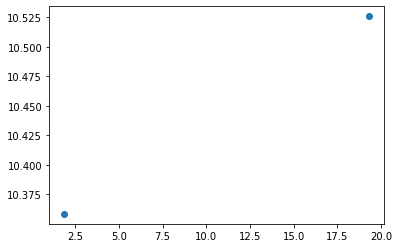

In [34]:
from matplotlib import pyplot as plt
plt.scatter(ground_truth[:, 0], predictions[:, 0])
plt.show()

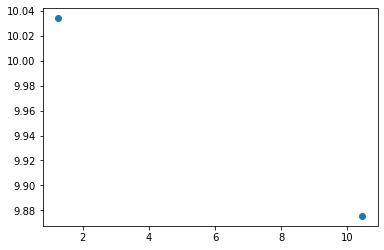

In [35]:
from matplotlib import pyplot as plt
plt.scatter(ground_truth[:, 1], predictions[:, 1])
plt.show()